In [60]:
from glob import glob

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from scipy.io import loadmat
from sklearn.metrics import classification_report, accuracy_score

import plotly.graph_objects as go

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [214]:
from glob import glob
S_sentinel_bands = glob("/tmp/shared/dataset_5/**/*B?*.tiff", recursive=True)
S_sentinel_bands.sort()
S_sentinel_bands

['/tmp/shared/dataset_5/city/13/0/2022-08-10-00_00_2022-08-10-23_59_Sentinel-2_L2A-0-B01_(Raw).tiff',
 '/tmp/shared/dataset_5/city/13/0/2022-08-10-00_00_2022-08-10-23_59_Sentinel-2_L2A-0-B02_(Raw).tiff',
 '/tmp/shared/dataset_5/city/13/0/2022-08-10-00_00_2022-08-10-23_59_Sentinel-2_L2A-0-B03_(Raw).tiff',
 '/tmp/shared/dataset_5/city/13/0/2022-08-10-00_00_2022-08-10-23_59_Sentinel-2_L2A-0-B04_(Raw).tiff',
 '/tmp/shared/dataset_5/city/13/0/2022-08-10-00_00_2022-08-10-23_59_Sentinel-2_L2A-0-B05_(Raw).tiff',
 '/tmp/shared/dataset_5/city/13/0/2022-08-10-00_00_2022-08-10-23_59_Sentinel-2_L2A-0-B06_(Raw).tiff',
 '/tmp/shared/dataset_5/city/13/0/2022-08-10-00_00_2022-08-10-23_59_Sentinel-2_L2A-0-B07_(Raw).tiff',
 '/tmp/shared/dataset_5/city/13/0/2022-08-10-00_00_2022-08-10-23_59_Sentinel-2_L2A-0-B08_(Raw).tiff',
 '/tmp/shared/dataset_5/city/13/0/2022-08-10-00_00_2022-08-10-23_59_Sentinel-2_L2A-0-B09_(Raw).tiff',
 '/tmp/shared/dataset_5/city/13/0/2022-08-10-00_00_2022-08-10-23_59_Sentinel-2_L2A

In [215]:
from urllib.parse import urlparse

def getCategory(path):
    url = path.split("/")
    category = url[4]
    return category

In [216]:
def getParentImageNumber(path):
    url = path.split("/")
    category = url[5]
    return category

In [217]:
def getImagePartNumber(path):
    url = path.split("/")
    category = url[6]
    return category

In [218]:
def toGrouped(array):
    np_array = np.asarray(array)
    print(f"Shape of array is {np_array.shape}")
    grouped_items = []
    for i in np_array:
        tpl = (i, getCategory(i), getParentImageNumber(i), getImagePartNumber(i))
        grouped_items.append(tpl)

    return np.asarray(grouped_items)

In [219]:
grouped_items = toGrouped(S_sentinel_bands)

Shape of array is (3618,)


In [220]:
grouped_items

array([['/tmp/shared/dataset_5/city/13/0/2022-08-10-00_00_2022-08-10-23_59_Sentinel-2_L2A-0-B01_(Raw).tiff',
        'city', '13', '0'],
       ['/tmp/shared/dataset_5/city/13/0/2022-08-10-00_00_2022-08-10-23_59_Sentinel-2_L2A-0-B02_(Raw).tiff',
        'city', '13', '0'],
       ['/tmp/shared/dataset_5/city/13/0/2022-08-10-00_00_2022-08-10-23_59_Sentinel-2_L2A-0-B03_(Raw).tiff',
        'city', '13', '0'],
       ...,
       ['/tmp/shared/dataset_5/water/6/8/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A-8-B11_(Raw).tiff',
        'water', '6', '8'],
       ['/tmp/shared/dataset_5/water/6/8/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A-8-B12_(Raw).tiff',
        'water', '6', '8'],
       ['/tmp/shared/dataset_5/water/6/8/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A-8-B8A_(Raw).tiff',
        'water', '6', '8']], dtype='<U101')

In [221]:
categories_to_include = ["city", "water", "forest", "field"]

In [222]:
def getLearnCategories():
    dataset_map = {}
    for category in categories_to_include:
        items = grouped_items[grouped_items[:, 1] == category]
        dataset_map[category] = items
    return dataset_map

In [223]:
categories_to_learn = getLearnCategories()

In [224]:
def createCategoriesNumbersMap():
    numbers_map = {}
    for idx, category in enumerate(categories_to_learn):
        numbers_map[category] = idx+1
    return numbers_map

In [225]:
categories_map = createCategoriesNumbersMap()

In [226]:
categories_map

{'city': 1, 'water': 2, 'forest': 3, 'field': 4}

In [227]:
from itertools import groupby

def prepareBeforeTraining():
    categories = {}
    for category_key, category_value in categories_to_learn.items():
        items = []
        image_part_items = groupby(category_value, key= lambda x: x[2])
        for key, group in image_part_items:
            grouped_parts = groupby(group, key=lambda x: x[3])
            for key1, group1 in grouped_parts:
                items.append(list(group1))
       # items = sorted(items)
        categories[category_key] = np.asarray(items)
    return categories

In [228]:
prepared_items = prepareBeforeTraining()

In [297]:
def loadImages():
    loaded_images = {}
    for category_key, category_value in prepared_items.items():
        ff = []
        for item in category_value:
            l = []

            if len(item) > 12:
                print(f"item {item[0][0]}")

            for file_path in item:
                with rio.open(file_path[0], 'r') as f:
                    img = f.read(1)
                    l.append(np.asarray(img))

            if len(l[0]) == len(l[1]) and len(l[0][0]) == len(l[1][0]):
                ff.append(np.asarray(l))
        loaded_images[category_key] = ff
    return loaded_images

In [298]:
loaded_images = loadImages()

In [286]:
fields  = loaded_images["field"]
for fld in fields:
    print(f"np shape {fld.shape}")
fields.shape

np shape (12, 50, 50)
np shape (12, 40, 40)
np shape (12, 40, 40)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 100, 100)
np shape (12, 100, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shap

AttributeError: 'list' object has no attribute 'shape'

In [299]:
import itertools

def createVectors():
    cat_vec = {}
    for cat_key, cat_val in loaded_images.items():
        print(f"Processing {cat_key}")
        itms = [[] for _ in range(12)]
        for img_group in cat_val:
            #grp = [[] for _ in range(12)]
            #print(f"Size of img group {len(img_group)}")
            for grp_idx,img in enumerate(img_group):
                #print(f"Index of type {grp_idx}. Array size: {len(grp)}")
                if len(img.shape) == 2:
                    vec = img.flatten()
                    itms[grp_idx].extend(vec)
            # if cat_key == "field":
            #         print(f"Size of itwm {len(itms[0])}")
        print(f"Size of {cat_key} is {len(itms[1])}")
        cat_vec[cat_key] = np.asarray(itms,  dtype=int)
    return cat_vec


In [300]:
vectors = createVectors()

Processing city
Size of city is 212500
Processing water
Size of water is 77500
Processing forest
Size of forest is 147500
Processing field
Size of field is 248200


In [301]:
vectors["field"].shape

(12, 248200)

In [303]:
def createYDatDict():
    y_dict = {}
    for val, num in categories_map.items():
        shape_length = vectors[val].shape[1]
        y_dict[val] = np.full(shape_length, num)
    return y_dict


In [165]:
t = [[] for _ in range(2)]
t[0].extend([1,2])
t[0].extend([3,4])
# t[0] = [1,2,3,4]
t[1].extend([5,6])
t[1].extend([7,8])
t

[[1, 2, 3, 4], [5, 6, 7, 8]]

In [304]:
y_data_cat = createYDatDict()

In [305]:
y_data_cat["city"].shape

(212500,)

In [306]:
def flattenXY():
    x_dt = [[] for _ in range(12)]
    for item in vectors.values():
        for idx, item1 in enumerate(item):
            x_dt[idx].extend(item1)

    y_dt = []
    for item in y_data_cat.values():
        y_dt.extend(item)

    x_array = np.asarray(x_dt)
    x_array_changed = np.moveaxis(x_array, -1, 0)

    return (np.asarray(x_array_changed), np.asarray(y_dt))

In [312]:
x_data, y_data = flattenXY()

In [365]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(x_data)

x_scaled = scaler.transform(x_data)

In [371]:
import random

def split_train_data(x, y, coef):
    cnt = x.shape[0]
    indexes = list(range(cnt))
    items_to_train = int(cnt*coef)
    items_to_test = cnt - items_to_train
    percentile = int((1-coef)*100.0)
    print(f"Train size: {items_to_train}. Test size: {items_to_test}")
    test_indexes = random.sample(indexes, items_to_test)

    x_train = []
    y_train = []
    x_test = []
    y_test = []
    for ii in range(cnt):
        if ii in test_indexes:
            x_test.append(x[ii])
            y_test.append(y[ii])
        else:
            x_train.append(x[ii])
            y_train.append(y[ii])
        print(f"Progress: {(ii/cnt)*100}")

    #print(f"items to train {x_train.shape}")
    #print(f"items to test {x_test.shape}")

    return (np.asarray(x_train), np.asarray(y_train), np.asarray(x_test), np.asarray(y_test))

In [373]:
def split_train_data2(x, y, coef):
    cnt = x.shape[0]
    items_to_train = int(cnt * coef)
    items_to_test = cnt - items_to_train
    percentile = int((1 - coef) * 100.0)
    print(f"Train size: {items_to_train}. Test size: {items_to_test}")
    test_indexes = random.sample(range(cnt), items_to_test)

    x_train = x[np.logical_not(np.isin(np.arange(cnt), test_indexes))]
    y_train = y[np.logical_not(np.isin(np.arange(cnt), test_indexes))]
    x_test = x[np.isin(np.arange(cnt), test_indexes)]
    y_test = y[np.isin(np.arange(cnt), test_indexes)]

    return x_train, y_train, x_test, y_test

In [374]:
x_train,y_train,x_test,y_test = split_train_data2(x_scaled, y_data, 0.7)

Train size: 479989. Test size: 205711


In [375]:
x_train.shape

(479989, 12)

In [376]:
y_train.shape

(479989,)

In [377]:
x_test.shape

(205711, 12)

## Train using KNNC

In [378]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(x_train, y_train)

# knn_pred = knn.predict(X_test)

KNeighborsClassifier(n_neighbors=10)

In [334]:
a =[]
a[0] = 1

IndexError: list assignment index out of range

In [ ]:
import pickle

knnModelFile = "/tmp/shared/knnc_ne3.sav"

pickle.dump(knn, open(knnModelFile, 'wb'))

In [379]:
pred = knn.predict(x_test)

In [380]:
print(f"Accuracy: {accuracy_score(y_test, pred)*100}")

Accuracy: 97.56600279032234


In [381]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           1       0.97      0.96      0.97     64111
           2       1.00      0.99      0.99     22980
           3       0.97      0.99      0.98     44491
           4       0.97      0.98      0.98     74129

    accuracy                           0.98    205711
   macro avg       0.98      0.98      0.98    205711
weighted avg       0.98      0.98      0.98    205711



In [382]:
proba1 = knn.predict_proba(x_test)

In [341]:
!pip install skl2onnx

ERROR: Could not find a version that satisfies the requirement skl2onnx (from versions: none)
ERROR: No matching distribution found for skl2onnx


In [340]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

# Specify an initial type for the model ( similar to input shape for the model )
initial_type = [
    ( 'input_study_hours' , FloatTensorType( [None,12] ) )
]

# Write the ONNX model to disk
converted_model = convert_sklearn( knn , initial_types=initial_type )
with open( "/tmp/shared/knnc.onnx", "wb" ) as f:
    f.write( converted_model.SerializeToString() )

ModuleNotFoundError: No module named 'skl2onnx'

In [383]:
proba1.shape

(205711, 4)

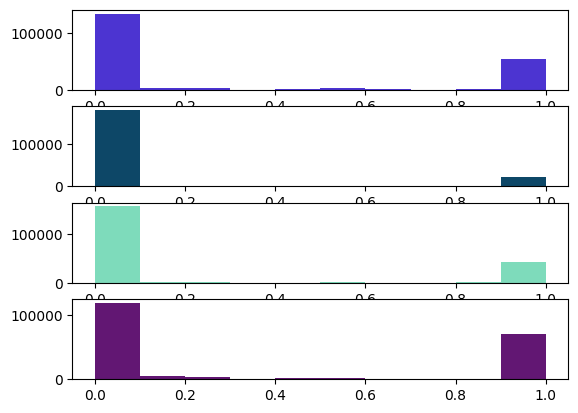

In [396]:
import matplotlib.pyplot as mplt

fig, axs = mplt.subplots(proba1.shape[1])

# axs[0].hist(proba1[:, 0])

for category in range(proba1.shape[1]):
    col = (np.random.random(), np.random.random(), np.random.random())
    axs[category].hist(proba1[:, category], color=col)

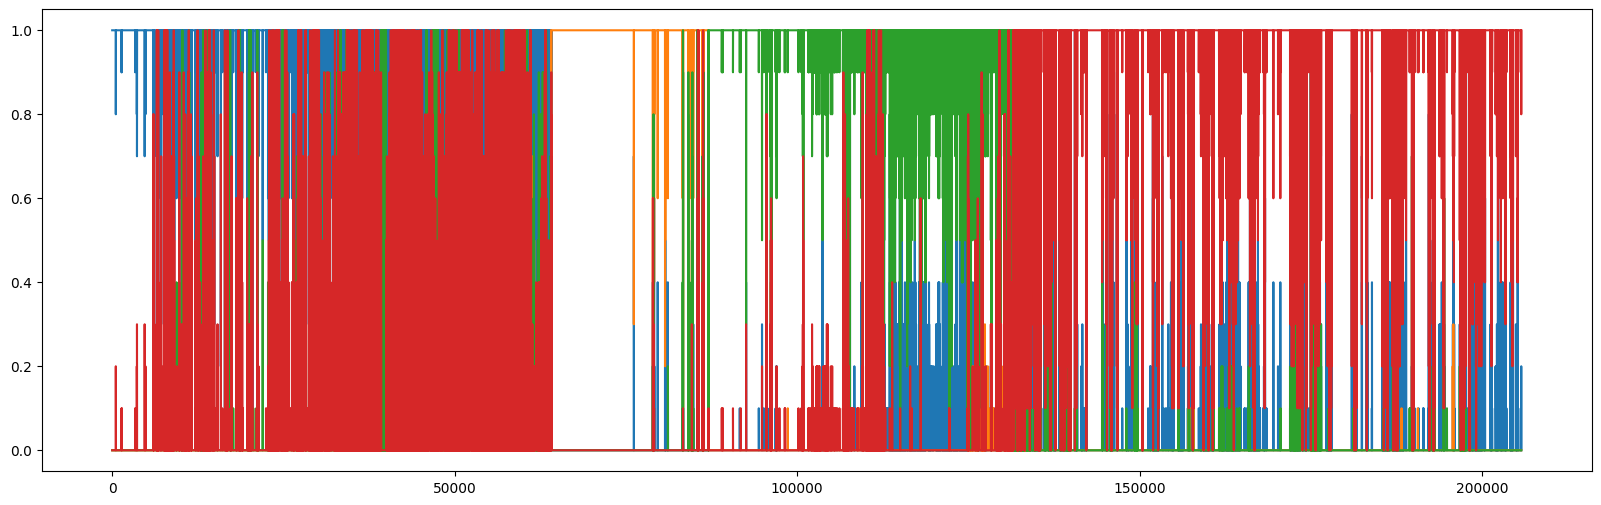

In [397]:
fig1, axs1 = mplt.subplots(figsize=(20,6))

for category in range(proba1.shape[1]):
    plt.plot(list(range(x_test.shape[0])), proba1[:, category])